In [14]:
from models.simsiam import SimSiam
from models.facecamera import FaceCameraModel
import torch
import util
from renderer import Renderer
from torchvision import transforms

DTYPE = torch.float
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = SimSiam().to(DEVICE)
net.load_state_dict(torch.load('/home/w0457094/git/photometric_optimization/checkpoints/resnet50-56-best.pth'))
# net = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50').to(DEVICE)
net.eval()

config = {
    # FLAME
    'flame_model_path': './data/generic_model.pkl',  # acquire it from FLAME project page
    'flame_lmk_embedding_path': './data/landmark_embedding.npy',
    'tex_space_path': './data/FLAME_texture.npz',  # acquire it from FLAME project page
    'camera_params': 3,
    'shape_params': 100,
    'expression_params': 50,
    'pose_params': 6,
    'tex_params': 50,
    'use_face_contour': True,

    'cropped_size': 256,
    'batch_size': 1,
    'image_size': 420,
    'e_lr': 0.005,
    'e_wd': 0.0001,
    'savefolder': './test_results/',
    # weights of losses and reg terms
    'w_pho': 8,
    'w_lmks': 1,
    'w_shape_reg': 1e-4,
    'w_expr_reg': 1e-4,
    'w_pose_reg': 0,
}

config = util.dict2obj(config)
util.check_mkdir(config.savefolder)

mesh_file = './data/head_template_mesh.obj'
render = Renderer(config.image_size, obj_filename=mesh_file).to(DEVICE)

normalise_trans = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


Using cache found in /home/w0457094/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/w0457094/anaconda3/envs/flametex1.9/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:533: UserWarning: Mtl file does not exist: ./data/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


creating the FLAME Decoder


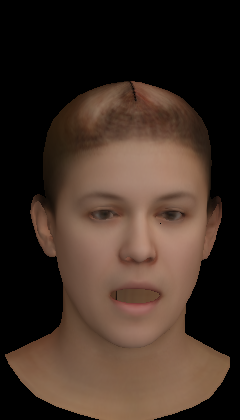

In [15]:
# sample flame
# pose_params = torch.tensor([[0.02, 0.1, 0.0, -0.03, 0.01, 0.03]], device=DEVICE)
pose_params = torch.tensor([[0.2, 0.1, -.02, 0.2, 0.00, -0.01]], device=DEVICE)
model = FaceCameraModel(config, render, DEVICE)
test_image_raw = model(pose=pose_params, return_alpha=False)[:,:,90:330]
test_image = normalise_trans(test_image_raw)
test_encoding = net(test_image[None,:,:,:].cuda()).detach()

pilimg = transforms.ToPILImage()(test_image_raw.detach().cpu()).convert("RGB")

pilimg

In [16]:
test_encoding[0,1:10]

tensor([-0.1213, -0.0094, -0.0122,  0.0327,  0.0638,  0.0583, -0.0208, -0.0150,
         0.0864], device='cuda:0')

In [23]:
pose_params2 = torch.tensor([[0, 0.2, -.08, 2., -0.10, -0.01]], device=DEVICE)
test_image_raw2 = model(pose=pose_params2, return_alpha=False)[:,:,90:330]
test_image2 = normalise_trans(test_image_raw2)
test_encoding2 = net(test_image2[None,:,:,:].cuda()).detach()

In [24]:
test_encoding2[0,1:10]

tensor([-0.1256, -0.0300, -0.0174,  0.0441,  0.0622,  0.0738, -0.0159, -0.0149,
         0.0861], device='cuda:0')

In [11]:
net

SimSiam(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (